<a href="https://colab.research.google.com/github/aman9213/CS6910-Assignment1/blob/master/assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tqdm import tqdm
from keras.datasets import fashion_mnist
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix
import warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install wandb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Loading the fashion-mnist data set

In [3]:
(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()

In [4]:
print("shape of data:",train_X.shape)
print(train_y)
print(test_y)

shape of data: (60000, 28, 28)
[9 0 0 ... 3 0 5]
[9 2 1 ... 8 1 5]


# Q1.ploting sample images from each class 

In [5]:

items,indices=np.unique(train_y,return_index=True)
print(indices)
print(items)
n_classes=len(items)
print(n_classes)

[ 1 16  5  3 19  8 18  6 23  0]
[0 1 2 3 4 5 6 7 8 9]
10


<Figure size 720x504 with 0 Axes>

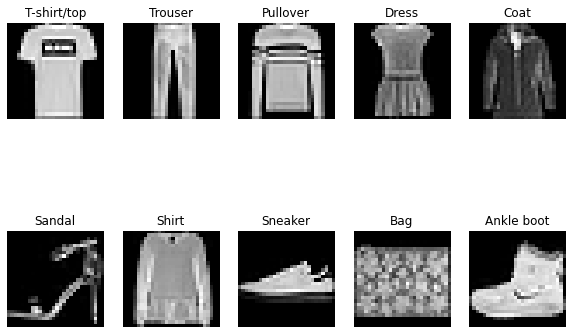

In [6]:
label=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 7))

rows=2
columns=5
fig = plt.figure(figsize=(10, 7))

for i,j in enumerate(indices):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(train_X[j],cmap ="gray")
        plt.axis('off')
        plt.title(label[i])


 logging the image to the wandb

In [7]:
import wandb


In [8]:

!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [9]:

wandb.init(project="DL-assignment1")
items,indices=np.unique(train_y,return_index=True)
labels=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

images = []
label = []
for i in (indices):
    images.append(train_X[i])
    label.append(labels[train_y[i]])
wandb.log({"Sample Image": [wandb.Image(img, caption=lbl) for img,lbl in zip(images, label)]})




wandb: Currently logged in as: amanvb-9213. Use `wandb login --relogin` to force relogin


In [10]:
#splitting train_X into training and validation set
X_train,X_validation=train_test_split(train_X,test_size=0.1,random_state=21,shuffle=True)
print("training data set:",X_train.shape,"\nvalidation data set:",X_validation.shape)
y_train,y_validation=train_test_split(train_y,test_size=0.1,random_state=21,shuffle=True)
print(y_train.shape,y_validation.shape)


training data set: (54000, 28, 28) 
validation data set: (6000, 28, 28)
(54000,) (6000,)


In [11]:
#making 2-D data matrix
X = np.array([itr.flatten() for itr in X_train])/255.0
X_test=np.array([itr.flatten() for itr in test_X])/255.0
validation_X=np.array([itr.flatten() for itr in X_validation])/255.0
#normalizing pixel


In [12]:
print(X.shape)
print(X_test.shape)
print(validation_X.shape)

(54000, 784)
(10000, 784)
(6000, 784)


 one hot encoding for 10 different of classes


In [13]:
#one hot encoding for y_train
y_train_one_hot = np.zeros((y_train.shape[0],10))
for i in range(y_train.shape[0]):
  y_train_one_hot[i,y_train[i]] = 1
#one hot encoding for y_validation
y_validation_one_hot = np.zeros((y_validation.shape[0],10))
for i in range(y_validation.shape[0]):
  y_validation_one_hot[i,y_validation[i]] = 1
#one hot encoding for test_y
test_y_one_hot = np.zeros((test_y.shape[0],10))
for i in range(test_y.shape[0]):
  test_y_one_hot[i,test_y[i]] = 1
print(y_train_one_hot[1])

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [14]:
input_nodes=X.shape[1]
output_nodes=10


###defining network size

In [15]:
def network_size(h_layers,h_nodes):
  nodes=[]
  nodes.append(input_nodes)
  for l in range(1,h_layers+1):
    nodes.append(h_nodes)
  nodes.append(output_nodes)

  return nodes

function for parameter initializtion and activaion function

In [16]:
def init_param(nodes,mode):
  layers=len(nodes)
  
  theta={}
  if mode=='random':
    for i in range(1,layers):
      theta["W"+str(i)]=np.random.randn(nodes[i-1],nodes[i])
      #print(theta["W"+str(i)].shape)
      theta["b"+str(i)]=np.zeros((1,nodes[i]))

  elif mode=='xavier':
    for i in range(1,layers):
       #theta["W"+str(i)]= np.random.randn(nodes[i-1],nodes[i])*np.sqrt(2/(nodes[i-1]+nodes[i]))
       theta["W"+str(i)]=np.random.normal(loc=0.0, scale=np.sqrt(2/(nodes[i-1]+nodes[i])), size=(nodes[i-1],nodes[i]))
       theta["b"+str(i)]=np.zeros((1,nodes[i]))
  layers=0  
  return theta

#activation functions

def sigmoid(x):
  return np.float64(1/(1+(np.exp(-x))))
  
 
def softmax(z):
    #assert len(z.shape) == 1
    s = np.max(z, axis=1)
    s = s[:, np.newaxis] 
    e_x = np.exp(z - s)
    div = np.sum(e_x, axis=1)
    div = div[:, np.newaxis] 
    return e_x / div

def ReLU(x):
  return np.float64(np.maximum(0,x))
def tanh(x):
    return np.float64(np.tanh(x))
def identity(x):
  return np.float64(x)




####derivative of activation function

In [17]:
def activation_prime(x,activation):
  if activation=='sigmoid':
    return sigmoid(x)*(1-sigmoid(x))
  elif activation=='ReLU':
    #  d=np.zeros_like(x,dtype=np.float64)
    #  d[x>0]=1
     return 1.*(x>0)
  elif activation=='tanh':
    return  (1 - (tanh(x)**2))
  elif activation=='identity':
    x1=np.ones_like(x,dtype=np.float64)
  return x1




###function for forward propagation

In [18]:
def feed_forward(x,theta,activation):
  
  layers=len(theta)//2
  H=[None]
  A=[]
  H[0]=np.array([x])  
  abc=H[0]
  for i in range(1,layers):
    a=np.dot(abc,theta["W"+str(i)])+theta["b"+str(i)]
    A.append(a)
    if(i!=layers):
      if activation=='sigmoid':
        h=sigmoid(a)
        H.append(h)
      elif activation=='ReLU':
        h=ReLU(a)
        H.append(h)
        
      elif activation=='tanh':
        h=tanh(a)
        H.append(h)
      elif activation=='identity':
        h=identity(a)
        H.append(h)
        
    #else:
    #   y_hat=(softmax(a))
    abc=h
  a=np.dot(abc,theta["W"+str(layers)])+theta["b"+str(layers)]
  y_hat=(softmax(a))
  return y_hat,H,A
    


###function for backpropagation

In [20]:
def back_prop(y_hat,y,H,A,layers,theta,batch_size,activation,l2):
  # y_hat -- predicted output
  # y ---actual output
  # H--- output of evry hidden layers
  # A--- pre_activation
  # layers- no. of hidden layers
  # theta-- dictionary of weight and bises
  # l2 -- L2 reguralization parameter 

  grads={}  ## this is dictionary for storing gradients
  
  delta_A=y_hat-y
  for l in range(layers,0,-1):
    #print(H[l-1])
    grads["dW" + str(l)] = (np.matmul(np.array(H[l-1]).T,delta_A/batch_size))
    grads["dW"+str(l)]+=l2*theta["W"+str(l)]
    grads["db" + str(l)] = (np.sum(delta_A,axis=1,keepdims=True)/batch_size)##<---------
    if l>1:

      delta_A =(np.matmul(delta_A,theta["W"+str(l)].T))*activation_prime(A[l-2],activation) ## A is starting from 0 index thats why l-2
  return grads

       





### update function is use in different optimizers 

In [22]:
def updatess(nodes):
  layers=len(nodes)
  update={}

  for i in range(1,layers):
    update["W"+str(i)]=np.zeros((nodes[i-1],nodes[i]))
    update["b"+str(i)]=np.zeros((1,nodes[i]))
  return update

### function for re-initializing the weights to 0

In [24]:
def zero(xyz,layers):
  for l in range(1,layers+1):
    xyz["dW"+str(l)]=0
    xyz["db"+str(l)]=0
  return xyz


### gradient decent function with all optimizers

In [30]:
def gradient_decent(typee,batch_size,epoch,lr,theta,activation,l2,update):
  layers=len(theta)//2
  
  loss=[]
  if typee=='sgd':
    for e in tqdm(range(epoch)):
      xyz={}
      
      xyz=zero(xyz,layers)
      for i in range(X.shape[0]):
        y_hat,H,A=feed_forward(X[i],theta,activation)

        del_theta=back_prop(y_hat,y_train_one_hot[i],H,A,layers,theta,batch_size,activation,l2)
        #print("dw5",del_theta["dW"+str(5)])
        for l in range(1,layers+1):
        # if ("dW"+str(l)) in xyz:
        #   xyz["dW"+str(l)]=xyz["dW"+str(l)]+del_theta["dW"+str(l)]
        # else:
          xyz["dW"+str(l)]+=del_theta["dW"+str(l)]
        # if ("db"+str(l)) in xyz:
        #   xyz["db"+str(l)]=xyz["db"+str(l)]+del_theta["db"+str(l)]
        # else:
          xyz["db"+str(l)]+=del_theta["db"+str(l)]
        
        if (i+1)%batch_size==0:

          #print("dw4",del_theta["dW"+str(4)])
          for l in range(1,layers+1):
             theta["W"+str(l)]=theta["W"+str(l)]-lr*xyz["dW"+str(l)]
             theta["b"+str(l)]=theta["b"+str(l)]-lr*xyz["db"+str(l)]
          xyz=zero(xyz,layers) 
      if e%1==0:      
        y_hat,H,A=feed_forward(X,theta,activation)
        loss.append((-1.0 * np.sum(np.multiply(y_train_one_hot,np.log(y_hat+0.000000001))))/X.shape[0])
        print("epoch:",e+1,loss[-1])
        
          

  elif typee=='mgd':

    m=0.5   ##this is beta for momentum
    last_loss=0
    prv_updates=update
    for e in range(epoch):
      xyz={}
      xyz=zero(xyz,layers)
      for i in range(X.shape[0]):
        y_hat,H,A=feed_forward(X[i,:],theta,activation)
        #print(y_hat)
        del_theta=back_prop(y_hat,y_train_one_hot[i,:],H,A,layers,theta,batch_size,activation,l2)
        for l in range(1,layers+1):
        # if ("dW"+str(l)) in xyz:
        #   xyz["dW"+str(l)]=xyz["dW"+str(l)]+del_theta["dW"+str(l)]
        # else:
          xyz["dW"+str(l)]+=del_theta["dW"+str(l)]
        # if ("db"+str(l)) in xyz:
        #   xyz["db"+str(l)]=xyz["db"+str(l)]+del_theta["db"+str(l)]
        # else:
          xyz["db"+str(l)]+=del_theta["db"+str(l)]
        
        if (i+1)%batch_size==0:
          for l in range(1,layers+1):
            theta["W"+str(l)]=theta["W"+str(l)]-(m*prv_updates["W"+str(l)]+lr*xyz["dW"+str(l)])
            theta["b"+str(l)]=theta["b"+str(l)]-(m*prv_updates["b"+str(l)]+lr*xyz["db"+str(l)])
            prv_updates["W"+str(l)]=(m*prv_updates["W"+str(l)]+lr*xyz["dW"+str(l)])
            prv_updates["b"+str(l)]=(m*prv_updates["b"+str(l)]+lr*xyz["db"+str(l)])
          xyz=zero(xyz,layers)
      y_hat,H,A=feed_forward(X,theta,activation)
      loss.append((-1.0 * np.sum(np.multiply(y_train_one_hot,np.log(y_hat+0.000000001))))/X.shape[0])
      print("epoch:",e+1,loss[-1])
      

  elif typee=='nag': 
    m=0.5
    theta_look_ahead={}
    prv_updates=update
    for e in range(epoch):
      xyz={}
      xyz=zero(xyz,layers)
      for i in range(X.shape[0]):
        y_hat,H,A=feed_forward(X[i,:],theta,activation)
        for l in range(1,layers+1):
          theta_look_ahead["W"+str(l)]=theta["W"+str(l)]-m*prv_updates["W"+str(l)]
          theta_look_ahead["b"+str(l)]=theta["b"+str(l)]-m*prv_updates["b"+str(l)]


        del_theta=back_prop(y_hat,y_train_one_hot[i,:],H,A,layers,theta_look_ahead,batch_size,activation,l2)
        for l in range(1,layers+1):

          xyz["dW"+str(l)]+=del_theta["dW"+str(l)]

          xyz["db"+str(l)]+=del_theta["db"+str(l)]

        if (i+1)%batch_size==0:
          for l in range(1,layers+1):
            theta["W"+str(l)]=theta["W"+str(l)]-(m*prv_updates["W"+str(l)]+lr*xyz["dW"+str(l)])
            theta["b"+str(l)]=theta["b"+str(l)]-(m*prv_updates["b"+str(l)]+lr*xyz["db"+str(l)])
            prv_updates["W"+str(l)]=(m*prv_updates["W"+str(l)]+lr*xyz["dW"+str(l)])
            prv_updates["b"+str(l)]=(m*prv_updates["b"+str(l)]+lr*xyz["db"+str(l)])
          xyz=zero(xyz,layers)
      y_hat,H,A=feed_forward(X,theta,activation)
      loss.append((-1.0 * np.sum(np.multiply(y_train_one_hot,np.log(y_hat+0.000000001))))/X.shape[0])
      print("epoch:",e+1,loss[-1])

  elif typee=='rmsprop':
    accumulate_grad=update
    beta=0.5 #
    eps=0.000001
    
    for e in range(epoch):
      
      xyz={}
      xyz=zero(xyz,layers)
  
      for i in range(X.shape[0]):
        y_hat,H,A=feed_forward(X[i,:],theta,activation)
        del_theta=back_prop(y_hat,y_train_one_hot[i,:],H,A,layers,theta,batch_size,activation,l2)
        for l in range(1,layers+1):
          xyz["dW"+str(l)]+=del_theta["dW"+str(l)]
      
          xyz["db"+str(l)]+=del_theta["db"+str(l)]
        if (i+1)%batch_size==0:
          for l in range(1,layers+1):
            accumulate_grad["W"+str(l)]=beta*accumulate_grad["W"+str(l)]-(1-beta)*(xyz["dW"+str(l)])**2
            accumulate_grad["b"+str(l)]=beta*accumulate_grad["b"+str(l)]-(1-beta)*(xyz["db"+str(l)])**2
            theta["W"+str(l)]=theta["W"+str(l)]-(lr/np.sqrt(abs(accumulate_grad["W"+str(l)])+eps))*xyz["dW"+str(l)]
            theta["b"+str(l)]=theta["b"+str(l)]-(lr/np.sqrt(abs(accumulate_grad["b"+str(l)])+eps))*xyz["db"+str(l)]
          xyz=zero(xyz,layers)
      y_hat,H,A=feed_forward(X,theta,activation)
      loss.append((-1.0 * np.sum(np.multiply(y_train_one_hot,np.log(y_hat+0.000000001))))/X.shape[0])
      print("epoch:",e+1,loss[-1])


  elif typee=='adam':
    updates=update
    momentum=updates.copy()
    momentum_hat=updates.copy()
    accumulate_grad=updates.copy()
    accumulate_grad_hat=updates.copy()
    beta1=0.8
    beta2=0.8
    eps=0.000001
    
    for e in range(epoch):
      xyz={}
      xyz=zero(xyz,layers)
      for i in range(X.shape[0]):##------------
        y_hat,H,A=feed_forward(X[i,:],theta,activation)
        del_theta=back_prop(y_hat,y_train_one_hot[i,:],H,A,layers,theta,batch_size,activation,l2)
        for l in range(1,layers+1):

        # if ("dW"+str(l)) in xyz:
        #   xyz["dW"+str(l)]=xyz["dW"+str(l)]+del_theta["dW"+str(l)]
        # else:
          xyz["dW"+str(l)]+=del_theta["dW"+str(l)]
        # if ("db"+str(l)) in xyz:
          xyz["db"+str(l)]=xyz["db"+str(l)]+del_theta["db"+str(l)]
        # else:
        #   xyz["db"+str(l)]=del_theta["db"+str
        if (i+1)%batch_size==0:
          for l in range(1,layers+1):
            momentum["W"+str(l)]=beta1*momentum["W"+str(l)]+(1-beta1)*xyz["dW"+str(l)]  ##mt_w
            momentum["b"+str(l)]=beta1*momentum["b"+str(l)]+(1-beta1)*xyz["db"+str(l)]  ##mt_b
            accumulate_grad["W"+str(l)]=beta2*accumulate_grad["W"+str(l)]-(1-beta2)*(xyz["dW"+str(l)])**2 ##v_t
            accumulate_grad["b"+str(l)]=beta2*accumulate_grad["b"+str(l)]-(1-beta2)*(xyz["db"+str(l)])**2 #v_t
            momentum_hat["W"+str(l)]=momentum["W"+str(l)]/(1-np.power(beta1,e+1))  #mt_hat_w
            momentum_hat["b"+str(l)]=momentum["b"+str(l)]/(1-np.power(beta1,e+1))  #mt_hat_b
            accumulate_grad_hat["W"+str(l)]=accumulate_grad["W"+str(l)]/(1-np.power(beta2,e+1)) ##vt_hat_w
            accumulate_grad_hat["b"+str(l)]=accumulate_grad["b"+str(l)]/(1-np.power(beta2,e+1)) ##vt_hat_b
            theta["W"+str(l)]=theta["W"+str(l)]-(lr/np.sqrt(np.abs(accumulate_grad_hat["W"+str(l)]+eps)))*momentum_hat["W"+str(l)]
            theta["b"+str(l)]=theta["b"+str(l)]-(lr/np.sqrt(np.abs(accumulate_grad_hat["b"+str(l)]+eps)))*momentum_hat["b"+str(l)]
          xyz=zero(xyz,layers)
      y_hat,H,A=feed_forward(X,theta,activation)
      loss.append((-1.0 * np.sum(np.multiply(y_train_one_hot,np.log(y_hat+0.000000001))))/X.shape[0])
      print("epoch:",e+1,loss[-1])


    
  elif type=='nadam':
    updates=update
    momentum=updates.copy()
    momentum_hat=updates.copy()
    accumulate_grad=updates.copy()
    accumulate_grad_hat=updates.copy()
    beta1=0.8
    beta2=0.8
    eps=0.000001
    
    for e in range(epoch):
      xyz={}
      xyz=zero(xyz,layers)
      for i in range(X.shape[0]):##------------
        y_hat,H,A=feed_forward(X[i,:],theta,activation)
        del_theta=back_prop(y_hat,y_train_one_hot[i,:],H,A,layers,theta,batch_size,activation,l2)
        for l in range(1,layers+1):

        # if ("dW"+str(l)) in xyz:
        #   xyz["dW"+str(l)]=xyz["dW"+str(l)]+del_theta["dW"+str(l)]
        # else:
          xyz["dW"+str(l)]+=del_theta["dW"+str(l)]
        # if ("db"+str(l)) in xyz:
          xyz["db"+str(l)]=xyz["db"+str(l)]+del_theta["db"+str(l)]
          # else:
        #   xyz["db"+str(l)]=del_theta["db"+str(l)]
        if (i+1)%batch_size==0:
          for l in range(1,layers+1):
            momentum["W"+str(l)]=beta1*momentum["W"+str(l)]+(1-beta1)*xyz["dW"+str(l)]  ##mt_w-- is like avg. accumulation of gradient
            momentum["b"+str(l)]=beta1*momentum["b"+str(l)]+(1-beta1)*xyz["db"+str(l)]  ##mt_b-- is like avg accumulation of square of gradient
            accumulate_grad["W"+str(l)]=beta2*accumulate_grad["W"+str(l)]-(1-beta2)*(xyz["dW"+str(l)])**2 ##v_t
            accumulate_grad["b"+str(l)]=beta2*accumulate_grad["b"+str(l)]-(1-beta2)*(xyz["db"+str(l)])**2 #v_t
            momentum_hat["W"+str(l)]=momentum["W"+str(l)]/(1-np.power(beta1,e+1))  #mt_hat_w
            momentum_hat["b"+str(l)]=momentum["b"+str(l)]/(1-np.power(beta1,e+1))  #mt_hat_b
            accumulate_grad_hat["W"+str(l)]=accumulate_grad["W"+str(l)]/(1-np.power(beta2,e+1)) ##vt_hat_w
            accumulate_grad_hat["b"+str(l)]=accumulate_grad["b"+str(l)]/(1-np.power(beta2,e+1)) ##vt_hat_b
            theta["W"+str(l)]=theta["W"+str(l)]-(lr/np.sqrt(np.abs(accumulate_grad_hat["W"+str(l)]+eps)))*(beta1*momentum_hat["W"+str(l)]+((1-beta1)*xyz["dW"+str(l)]/(1-np.power(beta1,e+1))))
            theta["b"+str(l)]=theta["b"+str(l)]-(lr/np.sqrt(np.abs(accumulate_grad_hat["b"+str(l)]+eps)))*(beta1*momentum_hat["b"+str(l)]+((1-beta1)*xyz["db"+str(l)]/(1-np.power(beta1,e+1))))
          xyz=zero(xyz,layers)

    #### you can add new optimizer here
  return theta,loss


  

epoch: 1 9.944929954421923
epoch: 2 11.746998514743536
epoch: 3 12.483832006661007
epoch: 4 12.851575596275742
epoch: 5 13.766352194374246


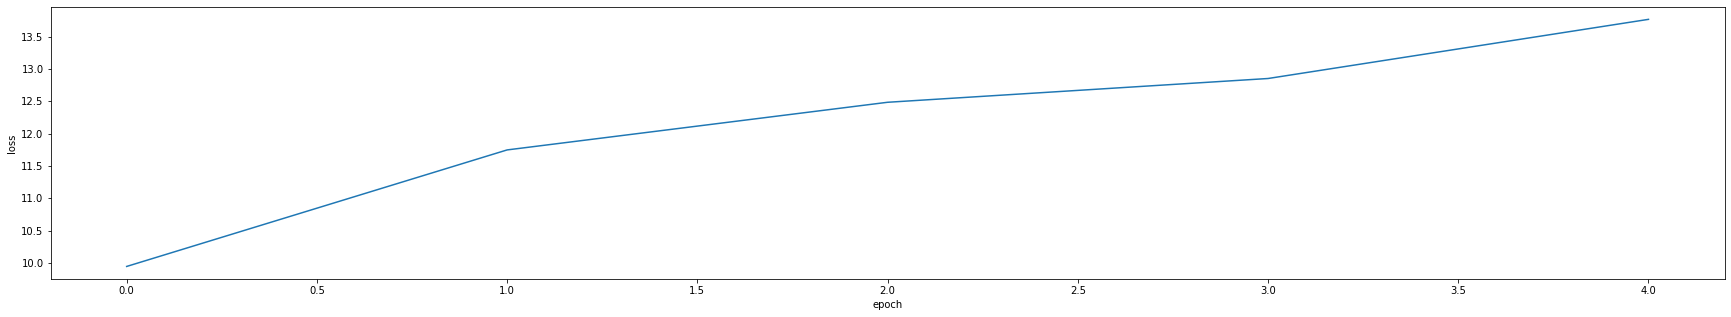

In [31]:
nodes=network_size(4,10)
theta=init_param(nodes,'xavier')
#print(len(theta))
update=updatess(nodes)
theta,loss=gradient_decent('adam',5,5,0.001,theta,'ReLU',0.0005,update)
#print(theta)
fig,axs=plt.subplots(figsize=(30,5))
plt.plot(loss)
plt.xlabel('epoch',size=10)
plt.ylabel('loss')
plt.show()



### Loss and accuracy function

In [32]:
##cross-entrophy loss function 
def loss_fun(y,y_predl,theta,l2):
  layers=len(theta)//2
  l2_regurlization=0
  loss=(-1.0 * np.sum(np.multiply(y_train_one_hot,np.log(y_predl+0.000000001))))/(X.shape[0])
  for l in range(1,layers+1):
    l2_regurlization+=(l2/(2*y.shape[0])*np.sum(np.square(theta["W"+str(l)])))
  loss=loss+l2_regurlization
  return loss

In [33]:
## Accuracy function
def accuracy(y, y_pred):
  correct=0
  for i in range(y.shape[0]):
    if np.argwhere(y[i])==np.argmax(y_pred[i]):
      correct+=1
  accuracy=(correct/y.shape[0])*100
  return accuracy
  





### wandb sweeping

In [35]:
sweep_configuration={'name':'EE22s037','method':'random',
                     'metric':{'name':'val_acc','goal':'maximize'},
                     'parameters':{
                                   'epochs':{'values':[4,5,10]},
                                   'hidden_layers':{'values':[3,4,5]},
                                   'numbers_neurons':{'values':[16,32,64]},
                                   'learning_rate':{'values':[1e-3,1e-4]},
                                   'optimizers':{'values':['sgd','mgd','nag','rmsprop','adam','nadam']},
                                   'batch_size':{'values':[16,32,64]},
                                   'wt_init':{'values':['random','xavier']},
                                   'activation':{'values':['sigmoid','tanh','ReLU']},
                                   'L2':{'values':[0,0.0005,0.5]}
                                   }
    
                     }
sweep_id=wandb.sweep(sweep=sweep_configuration,entity="amanvb-9213",project='DL-assignment1')



def tune():
  wandb.init()
  epochs=wandb.config.epochs
  h_layers=wandb.config.hidden_layers
  nodes=wandb.config.numbers_neurons
  lr=wandb.config.learning_rate
  optimizer=wandb.config.optimizers
  batch_size=wandb.config.batch_size
  init_mode=wandb.config.wt_init
  activation=wandb.config.activation
  l2=wandb.config.L2

  run_name="ep_{}_hl_{}_nodes_{}_lr_{}_opti_{}_bsize_{}_mode_{}_acf_{}".format(epochs,h_layers,nodes,lr,optimizer,batch_size,init_mode,activation,l2)
  print("run_name:",run_name)

  # train_Loss=[]
  train_Acc=[]
  val_Loss=[]
  val_Acc=[]
  nodes=network_size(h_layers,nodes)
  theta=init_param(nodes,init_mode)
  update=updatess(nodes)
  # for e in range(epochs):
  theta,loss=gradient_decent(optimizer,batch_size,epochs,lr,theta,activation,l2,update)



    ## finding loss on training data
  train_Loss=loss
    # y_predl,H,A=feed_forward(X,theta,activation)
    # train_loss=loss_fun(y_train_one_hot,y_predl,theta,l2)
    # train_Loss.append(train_loss)
    ##train accuracy
  y_preda,H,A=feed_forward(X,theta,activation)
  train_acc=accuracy(y_train_one_hot,y_preda)
  train_Acc.append(train_acc)



    ##finding validation loss
  y_pred,H,A=feed_forward(validation_X,theta,activation)
  val_loss=loss_fun(y_validation_one_hot,y_pred,theta,l2)
  val_Loss.append(val_loss)

    ##validation accuracy
  y_predva,H,A=feed_forward(validation_X,theta,activation)
  val_acc=accuracy(y_validation_one_hot,y_predva)
  val_Acc.append(val_acc)
  wandb.log({
        # 'epoch': e, 
        'train_acc': train_acc,
        'train_loss': train_Loss,  
        'val_acc': val_acc, 
        'val_loss': val_loss
      })
  print("max__train_accuracy:",np.max(train_Acc),"%")
  print("max__validation_accuracy:",np.max(val_Acc),"%")
  print("min_train_loss:",np.min(train_Loss))
  print("min_validation_loss:",np.min(val_Loss))
  plt.plot(train_Loss, 'r', label="Training loss")
  plt.plot(val_Loss, 'lime', label="Validation loss")
  plt.title("Training and Validation Loss vs Number of Epochs", size=15)
  plt.xlabel("Number of epochs", size=15)
  plt.ylabel("Loss", size=15)
  plt.legend()
  plt.show()  
  wandb.run.name = run_name
  wandb.run.save()
  wandb.run.finish()
  

wandb.agent(sweep_id,function=tune,count=20)















Error in callback <function _WandbInit._resume_backend at 0x7fc72313d310> (for pre_run_cell):


BrokenPipeError: ignored

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: plxq1s8v
Sweep URL: https://wandb.ai/amanvb-9213/DL-assignment1/sweeps/plxq1s8v


wandb: Agent Starting Run: uph1ul7w with config:
wandb: 	L2: 0.5
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	numbers_neurons: 32
wandb: 	optimizers: nag
wandb: 	wt_init: xavier
Exception in thread NetStatThr:
Traceback (most recent call last):
  File "/usr/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.9/threading.py", line 917, in run
Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "/usr/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.9/dist-packages/wandb/sdk/wandb_run.py", line 276, in check_stop_status
    self._loop_check_status(
  File "/usr/local/lib/python3.9/dist-packages/wandb/sdk/wandb_run.py", line 214, in _loop_check_status
    local_handle = request(

run_name: ep_5_hl_4_nodes_32_lr_0.0001_opti_nag_bsize_16_mode_xavier_acf_sigmoid
epoch: 1 11.640472106361074
epoch: 2 10.876411635439451
epoch: 1 10.896685327004379
epoch: 3 10.896543191104156
epoch: 4 10.896685227280221


epoch: 2 10.896685327004368
epoch: 3 10.896685327004368
epoch: 4 10.896685327004368
epoch: 5 10.896685327004368


wandb: ERROR Run uph1ul7w errored: IndexError('index 1 is out of bounds for axis 0 with size 1')
wandb: Agent Starting Run: 68ninrwd with config:
wandb: 	L2: 0
wandb: 	activation: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 4
wandb: 	hidden_layers: 3
wandb: 	learning_rate: 0.0001
wandb: 	numbers_neurons: 16
wandb: 	optimizers: nadam
wandb: 	wt_init: xavier


run_name: ep_4_hl_3_nodes_16_lr_0.0001_opti_nadam_bsize_32_mode_xavier_acf_sigmoid


wandb: ERROR Run 68ninrwd errored: IndexError('index 1 is out of bounds for axis 0 with size 1')
wandb: Agent Starting Run: 59xd48q7 with config:
wandb: 	L2: 0.5
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	numbers_neurons: 32
wandb: 	optimizers: nag
wandb: 	wt_init: xavier


run_name: ep_10_hl_4_nodes_32_lr_0.0001_opti_nag_bsize_64_mode_xavier_acf_sigmoid
epoch: 1 10.896685327004379
epoch: 2 10.896685327004368
epoch: 3 10.896685327004368
epoch: 4 10.896685327004368
epoch: 5 10.896685327004368
epoch: 6 10.896685327004368
epoch: 7 10.896685327004368
epoch: 8 10.896685327004368
epoch: 9 10.896685327004368
epoch: 10 10.896685327004368


wandb: ERROR Run 59xd48q7 errored: IndexError('index 1 is out of bounds for axis 0 with size 1')
wandb: Agent Starting Run: 4bummpa7 with config:
wandb: 	L2: 0
wandb: 	activation: ReLU
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	numbers_neurons: 64
wandb: 	optimizers: mgd
wandb: 	wt_init: random


run_name: ep_5_hl_4_nodes_64_lr_0.0001_opti_mgd_bsize_64_mode_random_acf_ReLU
epoch: 1 20.72173078021766
epoch: 2 20.72211454439984
epoch: 3 20.72211454439984
epoch: 4 20.722114544399826
epoch: 5 20.72211454439984


wandb: ERROR Run 4bummpa7 errored: IndexError('index 1 is out of bounds for axis 0 with size 1')
wandb: Agent Starting Run: 3yrs8246 with config:
wandb: 	L2: 0.5
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	numbers_neurons: 32
wandb: 	optimizers: nadam
wandb: 	wt_init: xavier


run_name: ep_5_hl_4_nodes_32_lr_0.0001_opti_nadam_bsize_16_mode_xavier_acf_sigmoid


wandb: ERROR Run 3yrs8246 errored: IndexError('index 1 is out of bounds for axis 0 with size 1')
wandb: Agent Starting Run: vl2pjw9i with config:
wandb: 	L2: 0.5
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: 4
wandb: 	learning_rate: 0.0001
wandb: 	numbers_neurons: 32
wandb: 	optimizers: sgd
wandb: 	wt_init: random


run_name: ep_5_hl_4_nodes_32_lr_0.0001_opti_sgd_bsize_16_mode_random_acf_tanh


 20%|██        | 1/5 [00:44<02:57, 44.42s/it]

epoch: 1 10.895665329106384


 40%|████      | 2/5 [01:27<02:10, 43.66s/it]

epoch: 2 10.896685325647596


 60%|██████    | 3/5 [02:11<01:27, 43.67s/it]

epoch: 3 10.896685327004421


 80%|████████  | 4/5 [02:54<00:43, 43.33s/it]

epoch: 4 10.896685327004368


100%|██████████| 5/5 [03:37<00:00, 43.41s/it]

epoch: 5 10.896685327004368


wandb: ERROR Run vl2pjw9i errored: IndexError('index 1 is out of bounds for axis 0 with size 1')
wandb: ERROR Detected 5 failed runs in a row at start, killing sweep.
wandb: To change this value set WANDB_AGENT_MAX_INITIAL_FAILURES=val


Error in callback <function _WandbInit._pause_backend at 0x7fc72313d280> (for post_run_cell):


BrokenPipeError: ignored